In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, Flatten, TimeDistributed, MaxPooling1D, Activation, Reshape, BatchNormalization

#Load and Prepare Data

In [ ]:
# load the raw data for each subset
def load_dataframe(subset_number):
    directory = 'C-MAPSS/'
    if not os.path.exists(directory):
        os.makedirs(directory)

#load the train file for each of the 4 subsets
    train_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/train_FD00{subset_number}.txt"
    os.system(f"wget -q {train_url} -O {directory}train_FD00{subset_number}.txt")
    turbo_train = pd.read_csv(f"{directory}train_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

#load the test file for each of the 4 subsets
    test_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/test_FD00{subset_number}.txt"
    os.system(f"wget -q {test_url} -O {directory}test_FD00{subset_number}.txt")
    turbo_test = pd.read_csv(f"{directory}test_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

#load the target (RUL) file for each of the 4 subsets
    rul_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/RUL_FD00{subset_number}.txt"
    os.system(f"wget -q {rul_url} -O {directory}RUL_FD00{subset_number}.txt")
    y_RUL = pd.read_csv(f"{directory}RUL_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    return turbo_train, turbo_test, y_RUL

In [ ]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [ ]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
#count the number of unique engines for each subset (useful for subsequent functions)
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [ ]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [ ]:
nr_train_1

100

In [ ]:
# assign the original RUL to the training set (assuming that RUL decreases linearly from the start)
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [ ]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [ ]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [ ]:
 # assign the original RUL to the testing set (assuming that RUL decreases linearly from the start)
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [ ]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [ ]:
turbo_test_1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
#concatenate training and testing set for subsequent operations
#reset engines indexes for the training set, so the count starts where the training engines left off (ex. for FD001, engine 1 becomes engine 101)
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [ ]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [ ]:
turbofan1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
# rename columns as in the original paper (Saxena and Goebel, 2008)
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf-dmd', 'PCNfR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [ ]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [ ]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


#Preprocessing

##Filtering

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing

In [ ]:
def exponential_smoothing(turbofan, smoothing_level):
    columns_to_exclude = ['ENr', 'C', 'RUL', 'OP-1', 'OP-2', 'OP-3']
    columns_to_smooth = turbofan.columns.difference(columns_to_exclude)

    smoothed_turbofan = turbofan.copy()

    for column in columns_to_smooth:
        smoothed_turbofan[column] = turbofan.groupby('ENr')[column].apply(
            lambda x: SimpleExpSmoothing(x, initialization_method="heuristic").fit(
                smoothing_level=smoothing_level, optimized=False
            ).fittedvalues
        ).reset_index(level=0, drop=True)

    return smoothed_turbofan

In [ ]:
filtered_turbo1=exponential_smoothing(turbofan1, 0.1)
filtered_turbo2=exponential_smoothing(turbofan2, 0.1)
filtered_turbo3=exponential_smoothing(turbofan3, 0.1)
filtered_turbo4=exponential_smoothing(turbofan4, 0.1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ig

In [ ]:
filtered_turbo1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,642.202000,1587.277333,1404.038000,14.62,...,2388.042000,8136.896000,8.418827,0.03,391.400000,2388.0,100.0,38.977333,23.384947,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.163800,1587.519600,1403.694200,14.62,...,2388.039800,8137.068400,8.418894,0.03,391.460000,2388.0,100.0,38.985600,23.388352,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.162420,1587.949640,1403.638780,14.62,...,2388.042820,8136.510560,8.420185,0.03,391.514000,2388.0,100.0,38.987040,23.391877,189
3,1,4,0.0007,0.0000,100.0,518.67,642.181178,1587.953676,1403.694902,14.62,...,2388.041538,8136.182504,8.419946,0.03,391.362600,2388.0,100.0,38.983336,23.387109,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.198060,1587.437308,1403.512412,14.62,...,2388.045384,8135.947254,8.414772,0.03,391.426340,2388.0,100.0,38.973002,23.385788,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,642.873126,1593.387101,1413.530015,14.62,...,2388.048958,8198.221641,8.450965,0.03,394.031053,2388.0,100.0,38.781093,23.287730,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,642.909814,1593.993391,1413.756014,14.62,...,2388.044063,8199.727477,8.453019,0.03,394.027948,2388.0,100.0,38.767984,23.278697,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,642.940832,1594.163052,1414.585412,14.62,...,2388.048656,8200.839729,8.452837,0.03,394.125153,2388.0,100.0,38.748185,23.278537,22
33725,200,197,-0.0038,0.0001,100.0,518.67,642.990749,1594.061747,1413.808871,14.62,...,2388.047791,8202.479756,8.453243,0.03,394.212638,2388.0,100.0,38.735367,23.271193,21


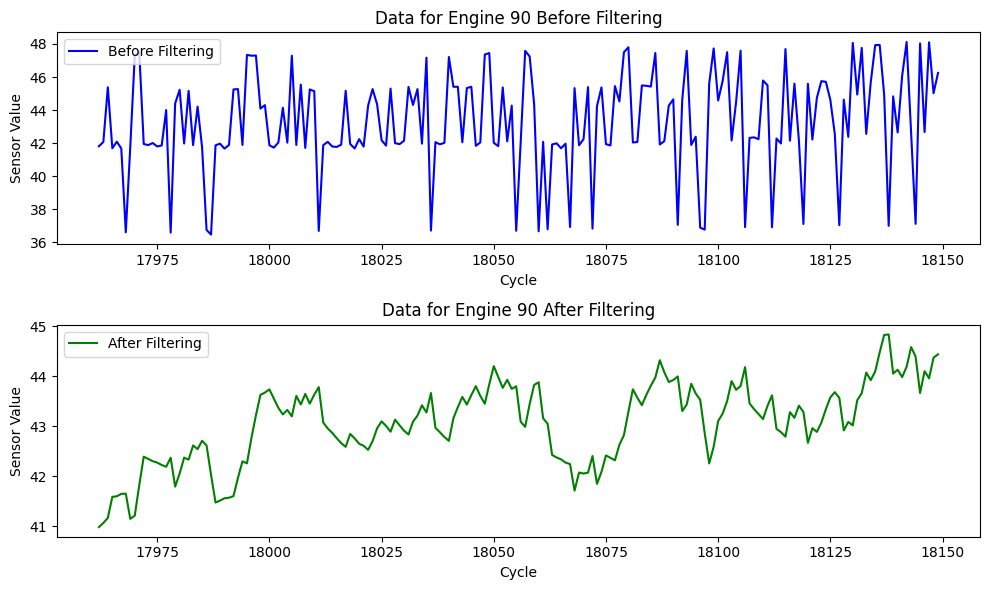

In [ ]:
def before_and_after(turbofan, filtered_turbo, engine_number):
    engine_data_before = turbofan[turbofan['ENr'] == engine_number]
    engine_data_after = filtered_turbo[filtered_turbo['ENr'] == engine_number]

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(engine_data_before['Ps30'], label='Before Filtering', color='blue')
    plt.title(f'Data for Engine {engine_number} Before Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(engine_data_after['Ps30'], label='After Filtering', color='green')
    plt.title(f'Data for Engine {engine_number} After Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

engine_number = 90
before_and_after(turbofan2, filtered_turbo2, engine_number)

##Normalization

In [ ]:
# perform z-score normalization (standardization)
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [ ]:
normalized_turbo1=z_score(filtered_turbo1)
normalized_turbo2=z_score(filtered_turbo2)
normalized_turbo3=z_score(filtered_turbo3)
normalized_turbo4=z_score(filtered_turbo4)

In [ ]:
normalized_turbo1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,-2.273737e-13,-1.060997,-0.460301,-0.354106,-5.329071e-15,...,-0.688611,-0.303931,-0.510671,6.938894e-18,-1.387005,-1.364242e-12,-2.842171e-14,0.907088,0.897956,191
1,1,2,0.870755,-1.032895,0.0,-2.273737e-13,-1.174896,-0.397975,-0.405491,-5.329071e-15,...,-0.728092,-0.291183,-0.508122,6.938894e-18,-1.328482,-9.094947e-13,-1.421085e-14,0.972650,0.943278,190
2,1,3,-1.956125,1.011877,0.0,-2.273737e-13,-1.179011,-0.287342,-0.413774,-5.329071e-15,...,-0.673896,-0.332431,-0.459269,6.938894e-18,-1.275811,-4.547474e-13,-1.421085e-14,0.984070,0.990191,189
3,1,4,0.323617,-0.010509,0.0,-2.273737e-13,-1.123081,-0.286303,-0.405386,-5.329071e-15,...,-0.696902,-0.356688,-0.468296,6.938894e-18,-1.423485,0.000000e+00,-1.421085e-14,0.954694,0.926736,188
4,1,5,-0.861849,-0.692099,0.0,-2.273737e-13,-1.072744,-0.419145,-0.432661,-5.329071e-15,...,-0.627879,-0.374083,-0.664169,6.938894e-18,-1.361314,4.547474e-13,-1.421085e-14,0.872739,0.909156,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,-2.273737e-13,0.940079,1.111509,1.064589,-5.329071e-15,...,-0.563737,4.230632,0.705859,6.938894e-18,1.179286,4.547474e-13,-1.421085e-14,-0.649273,-0.395934,24
33723,200,195,-0.497090,-0.351304,0.0,-2.273737e-13,1.049468,1.267484,1.098367,-5.329071e-15,...,-0.651597,4.341977,0.783589,6.938894e-18,1.176257,4.547474e-13,-1.421085e-14,-0.753242,-0.516156,23
33724,200,196,-0.269116,-1.032895,0.0,-2.273737e-13,1.141956,1.311131,1.222330,-5.329071e-15,...,-0.569159,4.424220,0.776705,6.938894e-18,1.271069,4.547474e-13,-1.421085e-14,-0.910261,-0.518281,22
33725,200,197,-1.728151,0.330287,0.0,-2.273737e-13,1.290791,1.285069,1.106267,-5.329071e-15,...,-0.584693,4.545487,0.792086,6.938894e-18,1.356401,4.547474e-13,-1.421085e-14,-1.011923,-0.616021,21


##Damage Modeling

In [ ]:
#split dataframe into train and test (only train is needed for damage modeling)
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [ ]:
turbo1_train, turbo1_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_train, turbo2_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_train, turbo3_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_train, turbo4_test=split_dataframe(normalized_turbo4, nr_train_4)

In [ ]:
turbo1_train

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,-2.273737e-13,-1.060997,-0.460301,-0.354106,-5.329071e-15,...,-0.688611,-0.303931,-0.510671,6.938894e-18,-1.387005,-1.364242e-12,-2.842171e-14,0.907088,0.897956,191
1,1,2,0.870755,-1.032895,0.0,-2.273737e-13,-1.174896,-0.397975,-0.405491,-5.329071e-15,...,-0.728092,-0.291183,-0.508122,6.938894e-18,-1.328482,-9.094947e-13,-1.421085e-14,0.972650,0.943278,190
2,1,3,-1.956125,1.011877,0.0,-2.273737e-13,-1.179011,-0.287342,-0.413774,-5.329071e-15,...,-0.673896,-0.332431,-0.459269,6.938894e-18,-1.275811,-4.547474e-13,-1.421085e-14,0.984070,0.990191,189
3,1,4,0.323617,-0.010509,0.0,-2.273737e-13,-1.123081,-0.286303,-0.405386,-5.329071e-15,...,-0.696902,-0.356688,-0.468296,6.938894e-18,-1.423485,0.000000e+00,-1.421085e-14,0.954694,0.926736,188
4,1,5,-0.861849,-0.692099,0.0,-2.273737e-13,-1.072744,-0.419145,-0.432661,-5.329071e-15,...,-0.627879,-0.374083,-0.664169,6.938894e-18,-1.361314,4.547474e-13,-1.421085e-14,0.872739,0.909156,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.177926,-1.032895,0.0,-2.273737e-13,2.480738,2.547181,2.657356,-5.329071e-15,...,2.521668,0.046801,2.820191,6.938894e-18,2.586245,4.547474e-13,-1.421085e-14,-3.093225,-2.551413,4
20627,100,197,-0.725065,-1.714485,0.0,-2.273737e-13,2.510603,2.521771,2.723766,-5.329071e-15,...,2.591857,0.016934,2.777713,6.938894e-18,2.735136,4.547474e-13,-1.421085e-14,-3.079692,-2.754083,3
20628,100,198,0.186832,-0.010509,0.0,-2.273737e-13,2.552390,2.666637,2.857519,-5.329071e-15,...,2.583244,-0.018081,2.808754,6.938894e-18,2.674061,4.547474e-13,-1.421085e-14,-3.218200,-2.689066,2
20629,100,199,-0.497090,1.011877,0.0,-2.273737e-13,2.554219,2.744535,2.897188,-5.329071e-15,...,2.611384,-0.015950,3.028604,6.938894e-18,2.911708,4.547474e-13,-1.421085e-14,-3.231825,-2.931473,1


##RUL Assignation

In [ ]:
#RULs taken from official solution
initial_RUL1=87
initial_RUL2= 110
initial_RUL3= 65
initial_RUL4=91

In [ ]:
#assign the initial RUL for the training set
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train = turbo_RUL_train.copy()
  max_cycle = turbo_RUL_train.groupby('ENr')['C'].transform('max')
  turbo_RUL_train['RUL'] = initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - (max_cycle - initial_RUL)
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [ ]:
turbo1_train=RUL_train(turbo1_train, initial_RUL1)

In [ ]:
turbo1_train

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,-2.273737e-13,-1.060997,-0.460301,-0.354106,-5.329071e-15,...,-0.688611,-0.303931,-0.510671,6.938894e-18,-1.387005,-1.364242e-12,-2.842171e-14,0.907088,0.897956,87
1,1,2,0.870755,-1.032895,0.0,-2.273737e-13,-1.174896,-0.397975,-0.405491,-5.329071e-15,...,-0.728092,-0.291183,-0.508122,6.938894e-18,-1.328482,-9.094947e-13,-1.421085e-14,0.972650,0.943278,87
2,1,3,-1.956125,1.011877,0.0,-2.273737e-13,-1.179011,-0.287342,-0.413774,-5.329071e-15,...,-0.673896,-0.332431,-0.459269,6.938894e-18,-1.275811,-4.547474e-13,-1.421085e-14,0.984070,0.990191,87
3,1,4,0.323617,-0.010509,0.0,-2.273737e-13,-1.123081,-0.286303,-0.405386,-5.329071e-15,...,-0.696902,-0.356688,-0.468296,6.938894e-18,-1.423485,0.000000e+00,-1.421085e-14,0.954694,0.926736,87
4,1,5,-0.861849,-0.692099,0.0,-2.273737e-13,-1.072744,-0.419145,-0.432661,-5.329071e-15,...,-0.627879,-0.374083,-0.664169,6.938894e-18,-1.361314,4.547474e-13,-1.421085e-14,0.872739,0.909156,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.177926,-1.032895,0.0,-2.273737e-13,2.480738,2.547181,2.657356,-5.329071e-15,...,2.521668,0.046801,2.820191,6.938894e-18,2.586245,4.547474e-13,-1.421085e-14,-3.093225,-2.551413,4
20627,100,197,-0.725065,-1.714485,0.0,-2.273737e-13,2.510603,2.521771,2.723766,-5.329071e-15,...,2.591857,0.016934,2.777713,6.938894e-18,2.735136,4.547474e-13,-1.421085e-14,-3.079692,-2.754083,3
20628,100,198,0.186832,-0.010509,0.0,-2.273737e-13,2.552390,2.666637,2.857519,-5.329071e-15,...,2.583244,-0.018081,2.808754,6.938894e-18,2.674061,4.547474e-13,-1.421085e-14,-3.218200,-2.689066,2
20629,100,199,-0.497090,1.011877,0.0,-2.273737e-13,2.554219,2.744535,2.897188,-5.329071e-15,...,2.611384,-0.015950,3.028604,6.938894e-18,2.911708,4.547474e-13,-1.421085e-14,-3.231825,-2.931473,1


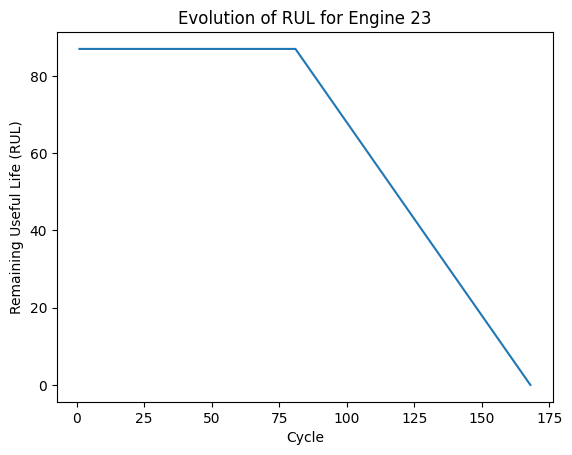

In [ ]:
#realsitic RUL trajectory
engine_number = 23
engine_df = turbo1_train[turbo1_train['ENr'] == engine_number]

plt.plot(engine_df['C'], engine_df['RUL'])
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Evolution of RUL for Engine {engine_number}')
plt.show()

In [ ]:
turbo2_train=RUL_train(turbo2_train, initial_RUL2)
turbo3_train=RUL_train(turbo3_train, initial_RUL3)
turbo4_train=RUL_train(turbo4_train, initial_RUL4)

In [ ]:
#assign RUL for the testing set
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
    turbo_RUL_test = turbo_RUL_test.copy()
    y_RUL_series = y_RUL[0]
    adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
    max_cycle = turbo_RUL_test.groupby('ENr')['C'].transform('max')+ y_RUL_series.iloc[adjusted_engine_numbers].values
    turbo_RUL_test['RUL'] = initial_RUL
    turbo_RUL_test.loc[turbo_RUL_test['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - (max_cycle - initial_RUL)
    turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
    return turbo_RUL_test

In [ ]:
turbo1_test=RUL_test(turbo1_test, initial_RUL1, nr_train_1, y_RUL_1)

In [ ]:
turbo1_test

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
20631,101,1,1.053135,1.011877,0.0,-2.273737e-13,0.016379,-0.885125,-1.270705,-5.329071e-15,...,-0.784322,-0.761732,-1.237444,6.938894e-18,-0.411620,-1.364242e-12,-2.842171e-14,0.880651,0.908958,87
20632,101,2,-1.226608,-1.032895,0.0,-2.273737e-13,0.152542,-0.893769,-1.266152,-5.329071e-15,...,-0.796286,-0.799847,-1.216348,6.938894e-18,-0.450635,-9.094947e-13,-1.421085e-14,0.790239,0.892623,87
20633,101,3,0.141238,0.330287,0.0,-2.273737e-13,-0.115510,-0.820254,-1.303753,-5.329071e-15,...,-0.753216,-0.730114,-1.291614,6.938894e-18,-0.388211,-4.547474e-13,-1.421085e-14,0.835762,0.902011,87
20634,101,4,1.919437,-0.010509,0.0,-2.273737e-13,-0.133131,-0.792937,-1.249113,-5.329071e-15,...,-0.768290,-0.737747,-1.117853,6.938894e-18,-0.332028,0.000000e+00,-1.421085e-14,0.924319,0.943734,87
20635,101,5,0.642781,-0.010509,0.0,-2.273737e-13,-0.154954,-0.840900,-1.124011,-5.329071e-15,...,-0.745966,-0.723912,-1.159817,6.938894e-18,-0.476542,4.547474e-13,-1.421085e-14,0.940572,0.924188,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,-2.273737e-13,0.940079,1.111509,1.064589,-5.329071e-15,...,-0.563737,4.230632,0.705859,6.938894e-18,1.179286,4.547474e-13,-1.421085e-14,-0.649273,-0.395934,24
33723,200,195,-0.497090,-0.351304,0.0,-2.273737e-13,1.049468,1.267484,1.098367,-5.329071e-15,...,-0.651597,4.341977,0.783589,6.938894e-18,1.176257,4.547474e-13,-1.421085e-14,-0.753242,-0.516156,23
33724,200,196,-0.269116,-1.032895,0.0,-2.273737e-13,1.141956,1.311131,1.222330,-5.329071e-15,...,-0.569159,4.424220,0.776705,6.938894e-18,1.271069,4.547474e-13,-1.421085e-14,-0.910261,-0.518281,22
33725,200,197,-1.728151,0.330287,0.0,-2.273737e-13,1.290791,1.285069,1.106267,-5.329071e-15,...,-0.584693,4.545487,0.792086,6.938894e-18,1.356401,4.547474e-13,-1.421085e-14,-1.011923,-0.616021,21


In [ ]:
turbo2_test=RUL_test(turbo2_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_test=RUL_test(turbo3_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_test=RUL_test(turbo4_test, initial_RUL4, nr_train_4, y_RUL_4)

##Prepare for Training

In [ ]:
drop_op_sett = ['OP-1', 'OP-2', 'OP-3']
turbo1_train.drop(columns=drop_op_sett, inplace=True)
turbo1_test.drop(columns=drop_op_sett, inplace=True)

turbo3_train.drop(columns=drop_op_sett, inplace=True)
turbo3_test.drop(columns=drop_op_sett, inplace=True)

In [ ]:
turbo1_train

,ENr,C,T2,T24,T30,T50,P2,P15,P30,Nf,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-2.273737e-13,-1.060997,-0.460301,-0.354106,-5.329071e-15,0.428057,1.192710,-0.132586,...,-0.688611,-0.303931,-0.510671,6.938894e-18,-1.387005,-1.364242e-12,-2.842171e-14,0.907088,0.897956,87
1,1,2,-2.273737e-13,-1.174896,-0.397975,-0.405491,-5.329071e-15,0.428057,1.187000,-0.156628,...,-0.728092,-0.291183,-0.508122,6.938894e-18,-1.328482,-9.094947e-13,-1.421085e-14,0.972650,0.943278,87
2,1,3,-2.273737e-13,-1.179011,-0.287342,-0.413774,-5.329071e-15,0.428057,1.090207,-0.214328,...,-0.673896,-0.332431,-0.459269,6.938894e-18,-1.275811,-4.547474e-13,-1.421085e-14,0.984070,0.990191,87
3,1,4,-2.273737e-13,-1.123081,-0.286303,-0.405386,-5.329071e-15,0.428057,1.079722,-0.194133,...,-0.696902,-0.356688,-0.468296,6.938894e-18,-1.423485,0.000000e+00,-1.421085e-14,0.954694,0.926736,87
4,1,5,-2.273737e-13,-1.072744,-0.419145,-0.432661,-5.329071e-15,0.428057,1.098834,-0.121864,...,-0.627879,-0.374083,-0.664169,6.938894e-18,-1.361314,4.547474e-13,-1.421085e-14,0.872739,0.909156,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-2.273737e-13,2.480738,2.547181,2.657356,-5.329071e-15,0.428056,-2.777740,2.414243,...,2.521668,0.046801,2.820191,6.938894e-18,2.586245,4.547474e-13,-1.421085e-14,-3.093225,-2.551413,4
20627,100,197,-2.273737e-13,2.510603,2.521771,2.723766,-5.329071e-15,0.428056,-2.826647,2.369923,...,2.591857,0.016934,2.777713,6.938894e-18,2.735136,4.547474e-13,-1.421085e-14,-3.079692,-2.754083,3
20628,100,198,-2.273737e-13,2.552390,2.666637,2.857519,-5.329071e-15,0.428056,-2.956308,2.402161,...,2.583244,-0.018081,2.808754,6.938894e-18,2.674061,4.547474e-13,-1.421085e-14,-3.218200,-2.689066,2
20629,100,199,-2.273737e-13,2.554219,2.744535,2.897188,-5.329071e-15,0.428056,-3.060983,2.449205,...,2.611384,-0.015950,3.028604,6.938894e-18,2.911708,4.547474e-13,-1.421085e-14,-3.231825,-2.931473,1


In [ ]:
#split data into arrays
def train_split(turbo_train, turbo_test):
  X_train=turbo_train.iloc[:, :-1]
  y_train=turbo_train.iloc[:, -1]

  X_test=turbo_test.iloc[:, :-1]
  y_test=turbo_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test=train_split(turbo1_train, turbo1_test)
y_test

20631    87
20632    87
20633    87
20634    87
20635    87
         ..
33722    24
33723    23
33724    22
33725    21
33726    20
Name: RUL, Length: 13096, dtype: int64

In [ ]:
X2_train, y2_train, X2_test, y2_test=train_split(turbo2_train, turbo2_test)
X3_train, y3_train, X3_test, y3_test=train_split(turbo3_train, turbo3_test)
X4_train, y4_train, X4_test, y4_test=train_split(turbo4_train, turbo4_test)

#Creating Sequences

In [ ]:
sequence_length = 25
def gen_sequences_and_labels(df, seq_length):
    sequences = []
    labels = []
    for _, group in df.groupby('ENr'):
        if len(group) >= seq_length:
            for i in range(len(group) - seq_length + 1):
                sequence = group.iloc[i:i+seq_length, :-1].values
                sequences.append(sequence)
                rul_values = group.iloc[i+seq_length-1, -1]
                labels.append(rul_values)
    return np.array(sequences), np.array(labels)

train_sequences, train_labels = gen_sequences_and_labels(turbo1_test, sequence_length)
test_sequences, test_labels = gen_sequences_and_labels(turbo1_test, sequence_length)

print("Train Sequences shape:", train_sequences.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Sequences shape:", test_sequences.shape)
print("Test Labels shape:", test_labels.shape)

Train Sequences shape: (10696, 25, 23)
Train Labels shape: (10696,)
Test Sequences shape: (10696, 25, 23)
Test Labels shape: (10696,)


In [ ]:
train_sequences

array([[[ 1.01000000e+02,  1.00000000e+00, -2.27373675e-13, ...,
         -2.84217094e-14,  8.80651209e-01,  9.08958056e-01],
        [ 1.01000000e+02,  2.00000000e+00, -2.27373675e-13, ...,
         -1.42108547e-14,  7.90239025e-01,  8.92623122e-01],
        [ 1.01000000e+02,  3.00000000e+00, -2.27373675e-13, ...,
         -1.42108547e-14,  8.35762353e-01,  9.02011495e-01],
        ...,
        [ 1.01000000e+02,  2.30000000e+01, -2.27373675e-13, ...,
         -1.42108547e-14,  1.04640994e+00,  8.59682387e-01],
        [ 1.01000000e+02,  2.40000000e+01, -2.27373675e-13, ...,
         -1.42108547e-14,  1.12976332e+00,  7.75207021e-01],
        [ 1.01000000e+02,  2.50000000e+01, -2.27373675e-13, ...,
         -1.42108547e-14,  1.07788707e+00,  8.03657113e-01]],

       [[ 1.01000000e+02,  2.00000000e+00, -2.27373675e-13, ...,
         -1.42108547e-14,  7.90239025e-01,  8.92623122e-01],
        [ 1.01000000e+02,  3.00000000e+00, -2.27373675e-13, ...,
         -1.42108547e-14,  8.35762353e

In [ ]:
train_sequences2, train_labels2 = gen_sequences_and_labels(turbo2_test, sequence_length)
test_sequences2, test_labels2 = gen_sequences_and_labels(turbo2_test, sequence_length)

train_sequences3, train_labels3 = gen_sequences_and_labels(turbo3_test, sequence_length)
test_sequences3, test_labels3 = gen_sequences_and_labels(turbo3_test, sequence_length)

train_sequences4, train_labels4 = gen_sequences_and_labels(turbo4_test, sequence_length)
test_sequences4, test_labels4 = gen_sequences_and_labels(turbo4_test, sequence_length)

#Neural Networks construction

In [ ]:
#testing the asymmetric scoring function
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [ ]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757


In [ ]:
#metrics for the neural networks
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(-dif / 13) - 1
    negative_score = tf.exp(-dif / 10) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

##FD001

In [ ]:
model = Sequential([
    LSTM(units=60, input_shape=(sequence_length, train_sequences.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])
learning_rate = 0.02
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 60)            20160     
                                                                 
 dropout (Dropout)           (None, 25, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 25, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 25, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 25, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 25, 60)            2

In [ ]:
history = model.fit(train_sequences, train_labels, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
134/134 [==============================] - 12s 25ms/step - loss: 1199.2869 - RMSE: 27.8747 - PHME_score: 420.6887 - MAE: 23.5828 - val_loss: 298.3819 - val_RMSE: 13.9539 - val_PHME_score: 1.7641 - val_MAE: 12.5689
Epoch 2/70
134/134 [==============================] - 2s 13ms/step - loss: 328.4968 - RMSE: 17.6274 - PHME_score: 1.8526 - MAE: 12.6879 - val_loss: 273.9963 - val_RMSE: 12.9509 - val_PHME_score: 0.6682 - val_MAE: 11.3972
Epoch 3/70
134/134 [==============================] - 2s 13ms/step - loss: 307.2597 - RMSE: 17.2439 - PHME_score: 1.2710 - MAE: 12.1666 - val_loss: 265.4175 - val_RMSE: 13.5307 - val_PHME_score: 0.7926 - val_MAE: 12.2251
Epoch 4/70
134/134 [==============================] - 2s 13ms/step - loss: 299.6110 - RMSE: 17.0427 - PHME_score: 1.1825 - MAE: 12.0222 - val_loss: 268.6552 - val_RMSE: 14.1447 - val_PHME_score: 1.0302 - val_MAE: 12.9822
Epoch 5/70
134/134 [==============================] - 2s 12ms/step - loss: 295.6532 - RMSE: 16.9553 - PHME_score

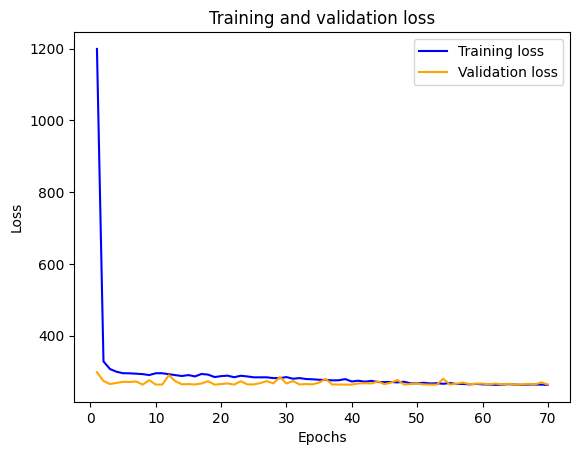

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences, test_labels, verbose=1, batch_size=64)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y_pred = model.predict(test_sequences, verbose=1, batch_size=64)
y_true = y_test

168/168 [==============================] - 1s 6ms/step - loss: 255.3045 - RMSE: 12.8494 - PHME_score: 0.7273 - MAE: 11.4323

RMSE: 12.849350929260254

PHME: 0.7272602915763855

MAE: 11.432319641113281
168/168 [==============================] - 2s 5ms/step


In [ ]:
predictions = model.predict(train_sequences)

predictions_flat = predictions[:, -1, 0]
assert train_labels.shape[0] == predictions_flat.shape[0], "Mismatch in number of samples after flattening."
r_squared = r2_score(train_labels, predictions_flat)
print("R-squared:", r_squared)

335/335 [==============================] - 2s 5ms/step
R-squared: -0.001640652922380248


##FD002

In [ ]:
model = Sequential([
    LSTM(units=60, input_shape=(sequence_length, train_sequences2.shape[2]) , return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])
learning_rate = 0.02
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 25, 60)            20880     
                                                                 
 dropout_6 (Dropout)         (None, 25, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 25, 60)            29040     
                                                                 
 dropout_7 (Dropout)         (None, 25, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 25, 60)            29040     
                                                                 
 dropout_8 (Dropout)         (None, 25, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 25, 60)           

In [ ]:
history = model.fit(train_sequences2, train_labels2, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
348/348 [==============================] - 12s 16ms/step - loss: 1253.8118 - RMSE: 31.5940 - PHME_score: 1392.8282 - MAE: 25.7072 - val_loss: 614.6187 - val_RMSE: 22.1465 - val_PHME_score: 2.7740 - val_MAE: 20.0532
Epoch 2/70
348/348 [==============================] - 4s 12ms/step - loss: 709.9559 - RMSE: 26.4111 - PHME_score: 3.5646 - MAE: 20.6014 - val_loss: 651.0171 - val_RMSE: 23.9122 - val_PHME_score: 4.5541 - val_MAE: 22.1242
Epoch 3/70
348/348 [==============================] - 4s 12ms/step - loss: 702.0992 - RMSE: 26.2734 - PHME_score: 3.3679 - MAE: 20.5128 - val_loss: 608.2641 - val_RMSE: 22.0029 - val_PHME_score: 2.5450 - val_MAE: 19.8980
Epoch 4/70
348/348 [==============================] - 4s 12ms/step - loss: 697.8535 - RMSE: 26.2183 - PHME_score: 3.2909 - MAE: 20.4612 - val_loss: 607.3945 - val_RMSE: 21.9325 - val_PHME_score: 2.4815 - val_MAE: 19.8122
Epoch 5/70
348/348 [==============================] - 4s 12ms/step - loss: 701.7378 - RMSE: 26.2909 - PHME_scor

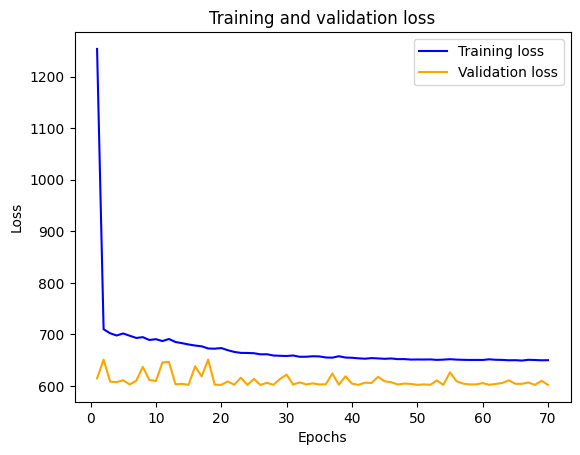

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(train_sequences2, train_labels2, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y2_pred = model.predict(train_sequences2,verbose=1, batch_size=200)
y2_true = y2_test

139/139 [==============================] - 1s 6ms/step - loss: 633.5613 - RMSE: 23.4142 - PHME_score: 1.7617 - MAE: 19.2964

RMSE: 23.414155960083008

PHME: 1.761726975440979

MAE: 19.29637908935547
139/139 [==============================] - 2s 6ms/step


In [ ]:
predictions = model.predict(train_sequences2)

predictions_flat = predictions[:, -1, 0]
assert train_labels2.shape[0] == predictions_flat.shape[0], "Mismatch in number of samples after flattening."
r_squared = r2_score(train_labels2, predictions_flat)
print("R-squared:", r_squared)

869/869 [==============================] - 4s 5ms/step
R-squared: -0.0008330090478723129


##FD003

In [ ]:
model = Sequential([
    LSTM(units=90, input_shape=(sequence_length, train_sequences3.shape[2]) , return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    LSTM(units=90, return_sequences=True),
    Dropout(0.1),
    Dense(units=90),
    Dropout(0.1),
    Dense(units=90),
    Dropout(0.1),
    Dense(units=90),
    Dense(units=1)
])
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 25, 90)            41040     
                                                                 
 dropout_12 (Dropout)        (None, 25, 90)            0         
                                                                 
 lstm_9 (LSTM)               (None, 25, 90)            65160     
                                                                 
 dropout_13 (Dropout)        (None, 25, 90)            0         
                                                                 
 lstm_10 (LSTM)              (None, 25, 90)            65160     
                                                                 
 dropout_14 (Dropout)        (None, 25, 90)            0         
                                                                 
 lstm_11 (LSTM)              (None, 25, 90)           

In [ ]:
history = model.fit(train_sequences3, train_labels3, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
178/178 [==============================] - 14s 28ms/step - loss: 373.7302 - RMSE: 13.5231 - PHME_score: 32.0856 - MAE: 11.1245 - val_loss: 84.5651 - val_RMSE: 5.2684 - val_PHME_score: 0.0772 - val_MAE: 4.1931
Epoch 2/70
178/178 [==============================] - 3s 17ms/step - loss: 75.7987 - RMSE: 8.2666 - PHME_score: 0.3131 - MAE: 5.4179 - val_loss: 80.6745 - val_RMSE: 5.9691 - val_PHME_score: 0.1855 - val_MAE: 5.0367
Epoch 3/70
178/178 [==============================] - 3s 17ms/step - loss: 72.9236 - RMSE: 8.1274 - PHME_score: 0.2927 - MAE: 5.2303 - val_loss: 85.6522 - val_RMSE: 4.5698 - val_PHME_score: -0.0509 - val_MAE: 3.3632
Epoch 4/70
178/178 [==============================] - 3s 17ms/step - loss: 71.0966 - RMSE: 8.0521 - PHME_score: 0.2721 - MAE: 5.0660 - val_loss: 80.7216 - val_RMSE: 6.1022 - val_PHME_score: 0.2095 - val_MAE: 5.1889
Epoch 5/70
178/178 [==============================] - 3s 17ms/step - loss: 71.6748 - RMSE: 8.0294 - PHME_score: 0.2790 - MAE: 5.1032 -

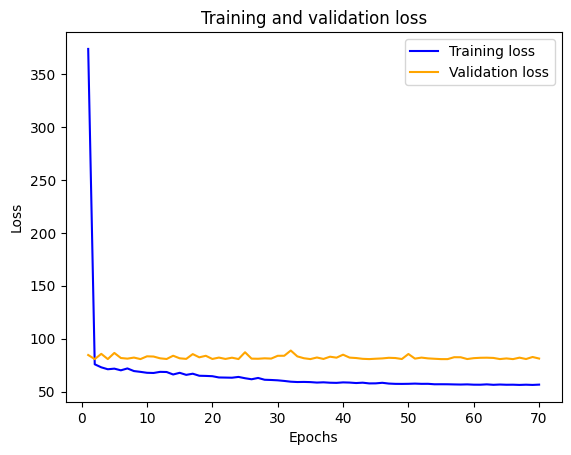

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences3, test_labels3, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y3_pred = model.predict(test_sequences3,verbose=1, batch_size=200)

71/71 [==============================] - 1s 8ms/step - loss: 59.1275 - RMSE: 5.5907 - PHME_score: 0.1384 - MAE: 3.5790

RMSE: 5.590681076049805

PHME: 0.13835088908672333

MAE: 3.5789759159088135
71/71 [==============================] - 2s 9ms/step


In [ ]:
predictions = model.predict(train_sequences3)

predictions_flat = predictions[:, -1, 0]
assert train_labels3.shape[0] == predictions_flat.shape[0], "Mismatch in number of samples after flattening."
r_squared = r2_score(train_labels3, predictions_flat)
print("R-squared:", r_squared)

444/444 [==============================] - 3s 6ms/step
R-squared: -6.765316902246354e-06


##FD004

In [ ]:
model = Sequential([
    LSTM(units=30, input_shape=(sequence_length, train_sequences4.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(units=30, return_sequences=True),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dense(units=1)
])
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAE])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 25, 30)            6840      
                                                                 
 dropout_20 (Dropout)        (None, 25, 30)            0         
                                                                 
 lstm_15 (LSTM)              (None, 25, 30)            7320      
                                                                 
 dropout_21 (Dropout)        (None, 25, 30)            0         
                                                                 
 dense_12 (Dense)            (None, 25, 30)            930       
                                                                 
 dropout_22 (Dropout)        (None, 25, 30)            0         
                                                                 
 dense_13 (Dense)            (None, 25, 30)           

In [ ]:
history = model.fit(train_sequences4, train_labels4, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
442/442 [==============================] - 10s 13ms/step - loss: 978.4218 - RMSE: 25.0875 - PHME_score: 427.2826 - MAE: 20.6001 - val_loss: 261.1077 - val_RMSE: 13.8049 - val_PHME_score: 1.4665 - val_MAE: 12.7698
Epoch 2/70
442/442 [==============================] - 4s 10ms/step - loss: 333.4323 - RMSE: 17.7740 - PHME_score: 1.7313 - MAE: 12.7698 - val_loss: 236.2554 - val_RMSE: 11.6622 - val_PHME_score: 0.6392 - val_MAE: 10.3619
Epoch 3/70
442/442 [==============================] - 4s 9ms/step - loss: 317.0859 - RMSE: 17.3670 - PHME_score: 1.4481 - MAE: 12.2288 - val_loss: 241.0014 - val_RMSE: 9.8778 - val_PHME_score: 0.1830 - val_MAE: 8.2123
Epoch 4/70
442/442 [==============================] - 4s 9ms/step - loss: 311.4387 - RMSE: 17.1995 - PHME_score: 1.3650 - MAE: 12.0422 - val_loss: 235.3701 - val_RMSE: 11.7492 - val_PHME_score: 0.6574 - val_MAE: 10.4702
Epoch 5/70
442/442 [==============================] - 4s 9ms/step - loss: 304.7387 - RMSE: 17.0409 - PHME_score: 1.27

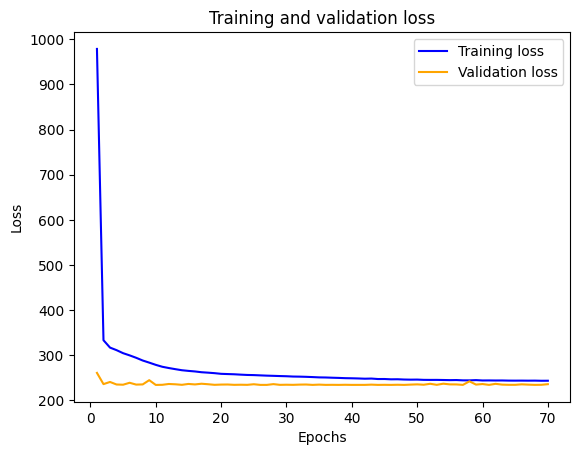

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences4, test_labels4, verbose=1, batch_size=300)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y4_pred = model.predict(test_sequences4,verbose=1, batch_size=300)
y4_true = y4_test

118/118 [==============================] - 1s 6ms/step - loss: 242.5964 - RMSE: 13.9755 - PHME_score: 0.7265 - MAE: 10.5158

RMSE: 13.975542068481445

PHME: 0.7264561653137207

MAE: 10.515807151794434
118/118 [==============================] - 1s 4ms/step


In [ ]:
predictions = model.predict(train_sequences4)

predictions_flat = predictions[:, -1, 0]
assert train_labels4.shape[0] == predictions_flat.shape[0], "Mismatch in number of samples after flattening."
r_squared = r2_score(train_labels4, predictions_flat)
print("R-squared:", r_squared)

1103/1103 [==============================] - 4s 4ms/step
R-squared: -0.00578710530896398
